In [ ]:
#Ingeniería del dato

# Estudio de la correlación entre variables
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la ruta del archivo en Google Colab
file_path = "/content/BBDD_final_limpio.xlsx"

# Cargar el archivo Excel
df = pd.read_excel(file_path)

# Calcular la matriz de correlación
correlation_matrix = df.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la ruta del archivo en Google Colab
file_path = "/content/BBDD_final_limpio.xlsx"

# Cargar el archivo Excel
df = pd.read_excel(file_path)

# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Crear un boxplot general para visualizar valores atípicos
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_numeric, orient="h", showfliers=True)
plt.title("Distribución de los datos y detección de valores atípicos")
plt.xlabel("Valor")
plt.show()

# Detectar valores atípicos usando el método del Rango Intercuartílico (IQR)
outliers = {}
outliers_percentage = {}

for col in df_numeric.columns:
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir umbrales para valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar valores atípicos
    outlier_values = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)][col]

    # Guardar la cantidad de valores atípicos y su porcentaje
    total_values = df_numeric[col].count()
    outliers[col] = outlier_values.count()
    outliers_percentage[col] = (outlier_values.count() / total_values) * 100 if total_values > 0 else 0

# Convertir los resultados en un DataFrame
df_outliers = pd.DataFrame.from_dict(outliers, orient='index', columns=["Cantidad de valores atípicos"])
df_outliers["Porcentaje de Atípicos (%)"] = df_outliers.index.map(outliers_percentage)

# Ordenar las variables con más valores atípicos detectados
df_outliers = df_outliers.sort_values(by="Cantidad de valores atípicos", ascending=False)

# Visualización de valores atípicos detectados en cada variable
plt.figure(figsize=(12, 6))
sns.barplot(x=df_outliers.index, y=df_outliers["Cantidad de valores atípicos"], palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Cantidad de valores atípicos por variable")
plt.xlabel("Variable")
plt.ylabel("Número de valores atípicos")
plt.show()

# Visualización del porcentaje de valores atípicos
plt.figure(figsize=(12, 6))
sns.barplot(x=df_outliers.index, y=df_outliers["Porcentaje de Atípicos (%)"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Porcentaje de valores atípicos por variable")
plt.xlabel("Variable")
plt.ylabel("Porcentaje (%)")
plt.show()

# Guardar los resultados en un archivo Excel para su análisis
df_outliers.to_excel("/content/Valores_Atipicos.xlsx")


In [ ]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definir la ruta del archivo en Google Colab
file_path = "/content/BBDD_final_limpio.xlsx"

# Cargar el archivo Excel
df = pd.read_excel(file_path)

# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Definir el número de filas y columnas para la disposición de los gráficos
num_vars = len(df_numeric.columns)
cols = 3  # Número de columnas en la cuadrícula
rows = int(np.ceil(num_vars / cols))  # Número de filas calculadas dinámicamente

# Crear subplots para múltiples histogramas en una sola imagen
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar histogramas para cada variable numérica
for i, column in enumerate(df_numeric.columns):
    axes[i].hist(df_numeric[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"{column}", fontsize=10)
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis='y', alpha=0.75)

# Eliminar cualquier subplot vacío
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño y mostrar la imagen final
plt.tight_layout()
plt.show()


In [1]:
#Análisis del dato

#Cálculo de R2
# 1. Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Generar variables temporales relevantes
df["Mes"] = df["Fecha_hora"].dt.month
df["DiaSemana"] = df["Fecha_hora"].dt.weekday
df["Hora"] = df["Fecha_hora"].dt.hour

# 6. Crear lags de producción energética para capturar tendencias
df["AL_solar_generacion_anterior"] = df["AL_solar_generacion_actual"].shift(1)
df["AL_generación_eolica_anterior"] = df["AL_generación_eolica_terrestre"].shift(1)

# Rellenar valores nulos creados por el lag con la media
df.fillna(df.mean(), inplace=True)

# 7. Aplicar Winsorization para reducir impacto de valores atípicos
outlier_vars = ["AL_solar_generacion_actual", "AL_capacidad_eolica_maritima",
                "IT_N_solar_generacion_actual", "IT_N_capacidad_eolica_maritima"]

for var in outlier_vars:
    df[var] = winsorize(df[var], limits=[0.01, 0.01])  # Recorta los extremos al 1%

# 8. Definir variables independientes y dependientes
variables_independientes = [
    "AL_capacidad_solar", "AL_capacidad_eolica_maritima", "AL_generación_eolica_maritima",
    "AL_capacidad_eolica_terrestre", "AL_generación_eolica_terrestre",
    "IT_N_capacidad_eolica_maritima", "IT_S_capacidad_eolica_maritima",
    "Mes", "DiaSemana", "Hora", "AL_solar_generacion_anterior", "AL_generación_eolica_anterior"
]

objetivos = [
    "AL_demanda_actual", "AL_demanda_predicha",
    "AL_solar_generacion_actual",
    "IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"
]

# 9. Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_independientes + objetivos] = scaler.fit_transform(df[variables_independientes + objetivos])

# 10. Reducir el tamaño del dataset para pruebas más rápidas
num_filas = len(df_scaled)
df_scaled = df_scaled.sample(n=min(55000, num_filas), random_state=42)

# 11. División en train (80%) y test (20%) para todas las variables dependientes
X = df_scaled[variables_independientes]
train_test_splits = {
    objetivo: train_test_split(X, df_scaled[objetivo], test_size=0.2, random_state=42)
    for objetivo in objetivos
}

# 12. Definir hiperparámetros optimizados manualmente para rapidez
rf_best_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist"
}

# 13. Inicializar modelos y calcular R² para cada variable dependiente
r2_results = []

for objetivo in objetivos:
    # Extraer datos de entrenamiento y prueba para la variable actual
    X_train, X_test, y_train, y_test = train_test_splits[objetivo]

    # Inicializar modelos con los hiperparámetros optimizados
    rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=42)

    # Entrenar los modelos
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Predicciones
    y_pred_rf = rf_model.predict(X_test)
    y_pred_xgb = xgb_model.predict(X_test)

    # Calcular R²
    r2_results.append({"Variable": objetivo, "Modelo": "Random Forest", "R²": r2_score(y_test, y_pred_rf)})
    r2_results.append({"Variable": objetivo, "Modelo": "XGBoost", "R²": r2_score(y_test, y_pred_xgb)})

# 14. Convertir resultados en DataFrame
df_r2 = pd.DataFrame(r2_results)
print(df_r2)


KeyboardInterrupt: 

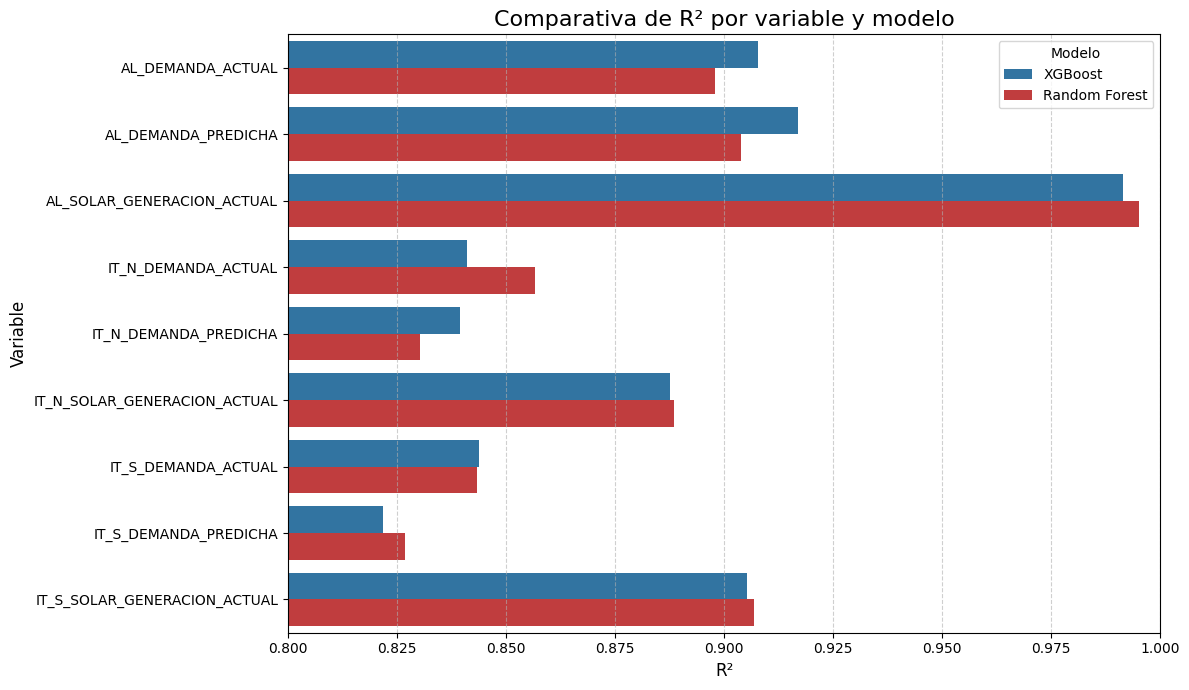

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos
data = {
    "VARIABLE": [
        "AL_DEMANDA_ACTUAL", "AL_DEMANDA_PREDICHA", "AL_SOLAR_GENERACION_ACTUAL",
        "AL_DEMANDA_ACTUAL", "AL_DEMANDA_PREDICHA", "AL_SOLAR_GENERACION_ACTUAL",
        "IT_N_DEMANDA_ACTUAL", "IT_N_DEMANDA_PREDICHA", "IT_N_SOLAR_GENERACION_ACTUAL",
        "IT_S_DEMANDA_ACTUAL", "IT_S_DEMANDA_PREDICHA", "IT_S_SOLAR_GENERACION_ACTUAL",
        "IT_N_DEMANDA_ACTUAL", "IT_N_DEMANDA_PREDICHA", "IT_N_SOLAR_GENERACION_ACTUAL",
        "IT_S_DEMANDA_ACTUAL", "IT_S_DEMANDA_PREDICHA", "IT_S_SOLAR_GENERACION_ACTUAL"
    ],
    "MODELO": [
        "XGBoost", "XGBoost", "XGBoost",
        "Random Forest", "Random Forest", "Random Forest",
        "XGBoost", "XGBoost", "XGBoost",
        "XGBoost", "XGBoost", "XGBoost",
        "Random Forest", "Random Forest", "Random Forest",
        "Random Forest", "Random Forest", "Random Forest"
    ],
    "R2": [
        0.907789, 0.916987, 0.991388,
        0.897973, 0.903900, 0.995053,
        0.841138, 0.839420, 0.887684,
        0.843827, 0.821776, 0.905163,
        0.856723, 0.830357, 0.888541,
        0.843459, 0.826926, 0.906760
    ]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Colores personalizados
palette = {
    "XGBoost": "#1f77b4",         # Azul
    "Random Forest": "#d62728"    # Rojo
}

# Gráfico
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x="R2", y="VARIABLE", hue="MODELO", palette=palette)
plt.title("Comparativa de R² por variable y modelo", fontsize=16)
plt.xlabel("R²", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.xlim(0.8, 1.0)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()


In [ ]:
#Cálculo de MAE:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Generar variables temporales relevantes
df["Mes"] = df["Fecha_hora"].dt.month
df["DiaSemana"] = df["Fecha_hora"].dt.weekday
df["Hora"] = df["Fecha_hora"].dt.hour

# 6. Crear lags de producción energética para capturar tendencias recientes
df["AL_solar_generacion_anterior"] = df["AL_solar_generacion_actual"].shift(1)
df["AL_generación_eolica_anterior"] = df["AL_generación_eolica_terrestre"].shift(1)

# Rellenar valores nulos creados por el lag con la media
df.fillna(df.mean(), inplace=True)

# 7. Aplicar Winsorization para reducir impacto de valores atípicos
outlier_vars = ["AL_solar_generacion_actual", "AL_capacidad_eolica_maritima",
                "IT_N_solar_generacion_actual", "IT_N_capacidad_eolica_maritima"]

for var in outlier_vars:
    df[var] = winsorize(df[var], limits=[0.01, 0.01])

# 8. Definir variables independientes (predictores) y dependientes (objetivo)
variables_independientes = [
    "AL_capacidad_solar", "AL_capacidad_eolica_maritima", "AL_generación_eolica_maritima",
    "AL_capacidad_eolica_terrestre", "AL_generación_eolica_terrestre",
    "IT_N_capacidad_eolica_maritima", "IT_S_capacidad_eolica_maritima",
    "Mes", "DiaSemana", "Hora", "AL_solar_generacion_anterior", "AL_generación_eolica_anterior"
]

objetivos = [
    "AL_demanda_actual", "AL_demanda_predicha",
    "AL_solar_generacion_actual",
    "IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"
]

# 9. Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_independientes + objetivos] = scaler.fit_transform(df[variables_independientes + objetivos])

# 10. Reducir el tamaño del dataset para pruebas más rápidas
num_filas = len(df_scaled)
df_scaled = df_scaled.sample(n=min(55000, num_filas), random_state=42)

# 11. División en train (80%) y test (20%) para todas las variables dependientes
X = df_scaled[variables_independientes]
train_test_splits = {
    objetivo: train_test_split(X, df_scaled[objetivo], test_size=0.2, random_state=42)
    for objetivo in objetivos
}

# 12. Definir hiperparámetros optimizados manualmente para rapidez
rf_best_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist"
}

# 13. Inicializar modelos y calcular MAE para cada variable dependiente
mae_results = []

for objetivo in objetivos:
    # Extraer datos de entrenamiento y prueba para la variable actual
    X_train, X_test, y_train, y_test = train_test_splits[objetivo]

    # Inicializar modelos con los hiperparámetros optimizados
    rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=42)

    # Entrenar los modelos
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Predicciones
    y_pred_rf = rf_model.predict(X_test)
    y_pred_xgb = xgb_model.predict(X_test)

    # Calcular MAE
    mae_results.append({"Variable": objetivo, "Modelo": "Random Forest", "MAE": mean_absolute_error(y_test, y_pred_rf)})
    mae_results.append({"Variable": objetivo, "Modelo": "XGBoost", "MAE": mean_absolute_error(y_test, y_pred_xgb)})

# 14. Convertir resultados en DataFrame y mostrar
df_mae = pd.DataFrame(mae_results)
print(df_mae)


                        Variable         Modelo       MAE
0              AL_demanda_actual  Random Forest  0.042815
1              AL_demanda_actual        XGBoost  0.042417
2            AL_demanda_predicha  Random Forest  0.039733
3            AL_demanda_predicha        XGBoost  0.038049
4     AL_solar_generacion_actual  Random Forest  0.009575
5     AL_solar_generacion_actual        XGBoost  0.013402
6            IT_N_demanda_actual  Random Forest  0.049502
7            IT_N_demanda_actual        XGBoost  0.052612
8          IT_N_demanda_predicha  Random Forest  0.053864
9          IT_N_demanda_predicha        XGBoost  0.052397
10  IT_N_solar_generacion_actual  Random Forest  0.047967
11  IT_N_solar_generacion_actual        XGBoost  0.050515
12           IT_S_demanda_actual  Random Forest  0.032293
13           IT_S_demanda_actual        XGBoost  0.032900
14         IT_S_demanda_predicha  Random Forest  0.043317
15         IT_S_demanda_predicha        XGBoost  0.044046
16  IT_S_solar

In [ ]:
#Cálculo del RMSE:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Generar variables temporales relevantes
df["Mes"] = df["Fecha_hora"].dt.month
df["DiaSemana"] = df["Fecha_hora"].dt.weekday
df["Hora"] = df["Fecha_hora"].dt.hour

# 6. Crear lags de producción energética para capturar tendencias recientes
df["AL_solar_generacion_anterior"] = df["AL_solar_generacion_actual"].shift(1)
df["AL_generación_eolica_anterior"] = df["AL_generación_eolica_terrestre"].shift(1)

# Rellenar valores nulos creados por el lag con la media
df.fillna(df.mean(), inplace=True)

# 7. Aplicar Winsorization para reducir impacto de valores atípicos
outlier_vars = ["AL_solar_generacion_actual", "AL_capacidad_eolica_maritima",
                "IT_N_solar_generacion_actual", "IT_N_capacidad_eolica_maritima"]

for var in outlier_vars:
    df[var] = winsorize(df[var], limits=[0.01, 0.01])  # Recorta los extremos al 1%

# 8. Definir variables independientes (predictores) y dependientes (objetivo)
variables_independientes = [
    "AL_capacidad_solar", "AL_capacidad_eolica_maritima", "AL_generación_eolica_maritima",
    "AL_capacidad_eolica_terrestre", "AL_generación_eolica_terrestre",
    "IT_N_capacidad_eolica_maritima", "IT_S_capacidad_eolica_maritima",
    "Mes", "DiaSemana", "Hora", "AL_solar_generacion_anterior", "AL_generación_eolica_anterior"
]

objetivos = [
    "AL_demanda_actual", "AL_demanda_predicha",
    "AL_solar_generacion_actual",
    "IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"
]

# 9. Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_independientes + objetivos] = scaler.fit_transform(df[variables_independientes + objetivos])

# 10. Reducir el tamaño del dataset para pruebas más rápidas
num_filas = len(df_scaled)  # Obtener número total de filas
df_scaled = df_scaled.sample(n=min(55000, num_filas), random_state=42)

# 11. División en train (80%) y test (20%) para todas las variables dependientes
X = df_scaled[variables_independientes]
train_test_splits = {
    objetivo: train_test_split(X, df_scaled[objetivo], test_size=0.2, random_state=42)
    for objetivo in objetivos
}

# 12. Definir hiperparámetros optimizados manualmente para rapidez
rf_best_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist"
}

# 13. Inicializar modelos y calcular RMSE para cada variable dependiente
rmse_results = []

for objetivo in objetivos:
    # Extraer datos de entrenamiento y prueba para la variable actual
    X_train, X_test, y_train, y_test = train_test_splits[objetivo]

    # Inicializar modelos con los hiperparámetros optimizados
    rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=42)

    # Entrenar los modelos
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Predicciones
    y_pred_rf = rf_model.predict(X_test)
    y_pred_xgb = xgb_model.predict(X_test)

    # Calcular RMSE
    rmse_results.append({"Variable": objetivo, "Modelo": "Random Forest", "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf))})
    rmse_results.append({"Variable": objetivo, "Modelo": "XGBoost", "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb))})

# 14. Convertir resultados en DataFrame y mostrar
df_rmse = pd.DataFrame(rmse_results)
print(df_rmse)


                        Variable         Modelo      RMSE
0              AL_demanda_actual  Random Forest  0.069739
1              AL_demanda_actual        XGBoost  0.066300
2            AL_demanda_predicha  Random Forest  0.063091
3            AL_demanda_predicha        XGBoost  0.058638
4     AL_solar_generacion_actual  Random Forest  0.018178
5     AL_solar_generacion_actual        XGBoost  0.023985
6            IT_N_demanda_actual  Random Forest  0.076410
7            IT_N_demanda_actual        XGBoost  0.080459
8          IT_N_demanda_predicha  Random Forest  0.082916
9          IT_N_demanda_predicha        XGBoost  0.080671
10  IT_N_solar_generacion_actual  Random Forest  0.097266
11  IT_N_solar_generacion_actual        XGBoost  0.097639
12           IT_S_demanda_actual  Random Forest  0.045277
13           IT_S_demanda_actual        XGBoost  0.045223
14         IT_S_demanda_predicha  Random Forest  0.059227
15         IT_S_demanda_predicha        XGBoost  0.060102
16  IT_S_solar

In [ ]:
#Comparación de R2 en Train y Test para comprobar la existencia de Overfitting o no
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Generar variables temporales relevantes
df["Mes"] = df["Fecha_hora"].dt.month
df["DiaSemana"] = df["Fecha_hora"].dt.weekday
df["Hora"] = df["Fecha_hora"].dt.hour

# 6. Crear lags de producción energética para capturar tendencias recientes
df["AL_solar_generacion_anterior"] = df["AL_solar_generacion_actual"].shift(1)
df["AL_generación_eolica_anterior"] = df["AL_generación_eolica_terrestre"].shift(1)

# Rellenar valores nulos creados por el lag con la media
df.fillna(df.mean(), inplace=True)

# 7. Aplicar Winsorization para reducir impacto de valores atípicos
outlier_vars = ["AL_solar_generacion_actual", "AL_capacidad_eolica_maritima",
                "IT_N_solar_generacion_actual", "IT_N_capacidad_eolica_maritima"]

for var in outlier_vars:
    df[var] = winsorize(df[var], limits=[0.01, 0.01])  # Recorta los extremos al 1%

# 8. Definir variables independientes (predictores) y dependientes (objetivo)
variables_independientes = [
    "AL_capacidad_solar", "AL_capacidad_eolica_maritima", "AL_generación_eolica_maritima",
    "AL_capacidad_eolica_terrestre", "AL_generación_eolica_terrestre",
    "IT_N_capacidad_eolica_maritima", "IT_S_capacidad_eolica_maritima",
    "Mes", "DiaSemana", "Hora", "AL_solar_generacion_anterior", "AL_generación_eolica_anterior"
]

objetivos = [
    "AL_demanda_actual", "AL_demanda_predicha",
    "AL_solar_generacion_actual",
    "IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"
]

# 9. Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_independientes + objetivos] = scaler.fit_transform(df[variables_independientes + objetivos])

# 10. Reducir el tamaño del dataset para pruebas más rápidas
num_filas = len(df_scaled)
df_scaled = df_scaled.sample(n=min(55000, num_filas), random_state=42)

# 11. División en train (80%) y test (20%) para todas las variables dependientes
X = df_scaled[variables_independientes]
train_test_splits = {
    objetivo: train_test_split(X, df_scaled[objetivo], test_size=0.2, random_state=42)
    for objetivo in objetivos
}

# 12. Definir hiperparámetros optimizados manualmente para rapidez
rf_best_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist"
}

# 13. Inicializar modelos y calcular R² para Train y Test en cada variable dependiente
r2_comparison = []

for objetivo in objetivos:
    # Extraer datos de entrenamiento y prueba para la variable actual
    X_train, X_test, y_train, y_test = train_test_splits[objetivo]

    # Inicializar modelos con los hiperparámetros optimizados
    rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=42)

    # Entrenar los modelos
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Predicciones en Train y Test
    y_pred_rf_train = rf_model.predict(X_train)
    y_pred_rf_test = rf_model.predict(X_test)

    y_pred_xgb_train = xgb_model.predict(X_train)
    y_pred_xgb_test = xgb_model.predict(X_test)

    # Calcular R² en Train y Test
    r2_comparison.append({"Variable": objetivo, "Modelo": "Random Forest", "R² Train": r2_score(y_train, y_pred_rf_train), "R² Test": r2_score(y_test, y_pred_rf_test)})
    r2_comparison.append({"Variable": objetivo, "Modelo": "XGBoost", "R² Train": r2_score(y_train, y_pred_xgb_train), "R² Test": r2_score(y_test, y_pred_xgb_test)})

# 14. Convertir resultados en DataFrame y mostrar
df_r2_comparison = pd.DataFrame(r2_comparison)
print(df_r2_comparison)


                        Variable         Modelo  R² Train   R² Test
0              AL_demanda_actual  Random Forest  0.908004  0.897973
1              AL_demanda_actual        XGBoost  0.909709  0.907789
2            AL_demanda_predicha  Random Forest  0.917080  0.903900
3            AL_demanda_predicha        XGBoost  0.920202  0.916987
4     AL_solar_generacion_actual  Random Forest  0.996830  0.995053
5     AL_solar_generacion_actual        XGBoost  0.992505  0.991388
6            IT_N_demanda_actual  Random Forest  0.876171  0.856723
7            IT_N_demanda_actual        XGBoost  0.847939  0.841138
8          IT_N_demanda_predicha  Random Forest  0.850438  0.830357
9          IT_N_demanda_predicha        XGBoost  0.847481  0.839420
10  IT_N_solar_generacion_actual  Random Forest  0.913999  0.888541
11  IT_N_solar_generacion_actual        XGBoost  0.901647  0.887684
12           IT_S_demanda_actual  Random Forest  0.871464  0.843459
13           IT_S_demanda_actual        XGBoost 

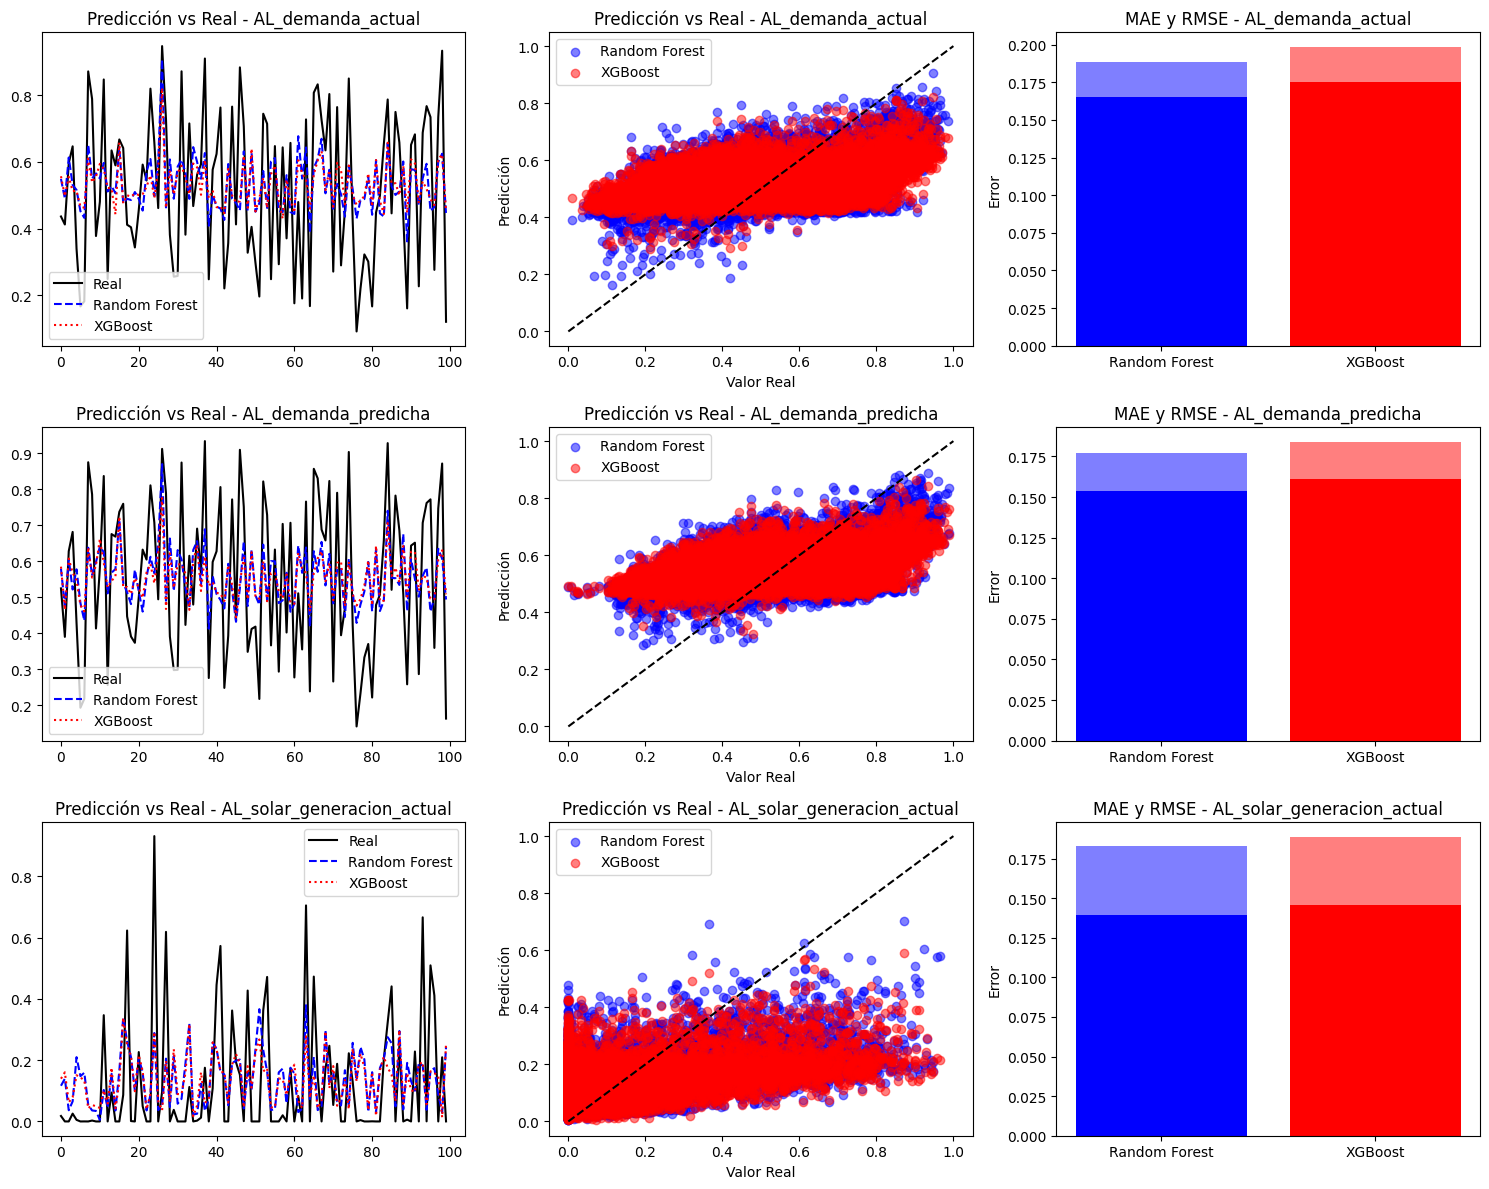

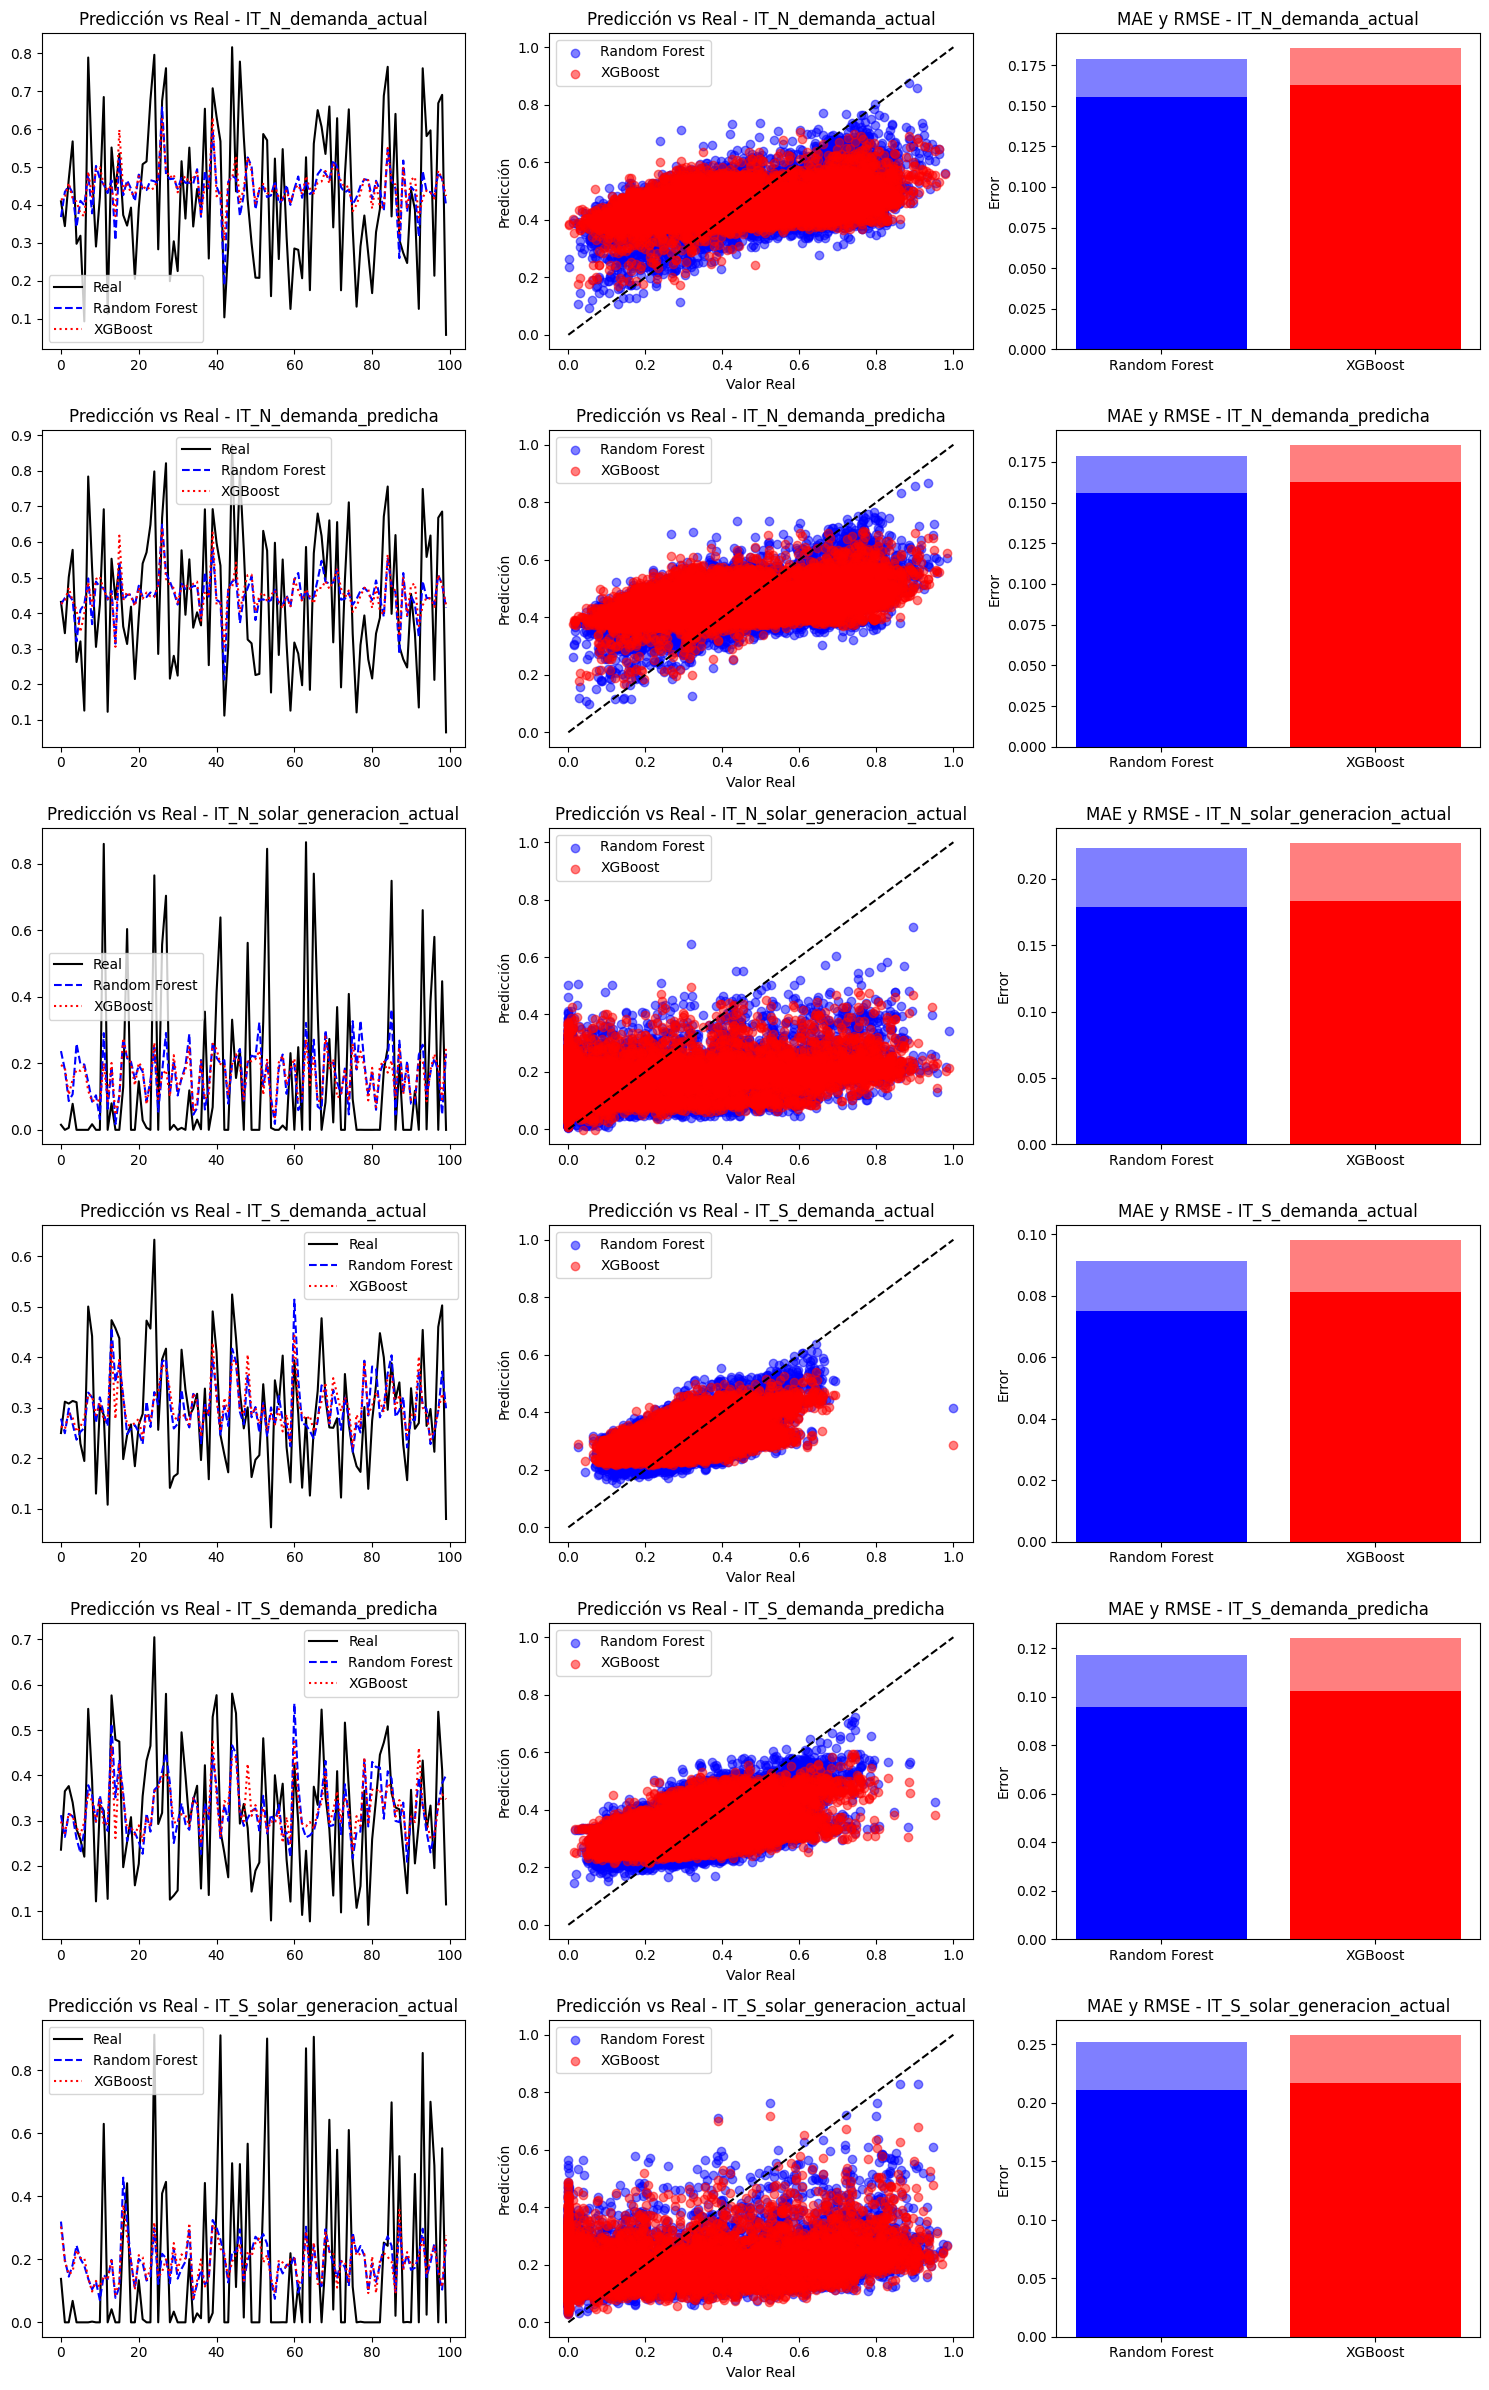

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Definir variables por países
variables_alemania = ["AL_demanda_actual", "AL_demanda_predicha", "AL_solar_generacion_actual"]
variables_italia = ["IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
                    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"]

variables_independientes = [col for col in df.columns if col not in variables_alemania + variables_italia + ["Fecha_hora"]]

# 6. Normalizar los datos
scaler = MinMaxScaler()
df[variables_independientes + variables_alemania + variables_italia] = scaler.fit_transform(df[variables_independientes + variables_alemania + variables_italia])

# 7. División en Train y Test
X = df[variables_independientes]
train_test_splits = {
    objetivo: train_test_split(X, df[objetivo], test_size=0.2, random_state=42)
    for objetivo in variables_alemania + variables_italia
}

# 8. Entrenar modelos y obtener predicciones
rf_best_params = {"n_estimators": 100, "max_depth": 10}
xgb_best_params = {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.05, "tree_method": "hist"}

resultados = {}

for objetivo in variables_alemania + variables_italia:
    X_train, X_test, y_train, y_test = train_test_splits[objetivo]

    rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=42)

    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    y_pred_xgb = xgb_model.predict(X_test)

    resultados[objetivo] = {
        "y_test": y_test,
        "y_pred_rf": y_pred_rf,
        "y_pred_xgb": y_pred_xgb
    }

# 9. Función para generar gráficos agrupados
def plot_combined_results(variables, country_name):
    fig, axes = plt.subplots(len(variables), 3, figsize=(15, len(variables) * 4))

    for i, objetivo in enumerate(variables):
        y_test = resultados[objetivo]["y_test"]
        y_pred_rf = resultados[objetivo]["y_pred_rf"]
        y_pred_xgb = resultados[objetivo]["y_pred_xgb"]

        # Gráfico de Series Temporales
        axes[i, 0].plot(y_test[:100].values, label="Real", color="black")
        axes[i, 0].plot(y_pred_rf[:100], label="Random Forest", color="blue", linestyle="dashed")
        axes[i, 0].plot(y_pred_xgb[:100], label="XGBoost", color="red", linestyle="dotted")
        axes[i, 0].set_title(f"Predicción vs Real - {objetivo}")
        axes[i, 0].legend()

        # Gráfico de Dispersión
        axes[i, 1].scatter(y_test, y_pred_rf, color="blue", alpha=0.5, label="Random Forest")
        axes[i, 1].scatter(y_test, y_pred_xgb, color="red", alpha=0.5, label="XGBoost")
        axes[i, 1].plot([0, 1], [0, 1], "k--")
        axes[i, 1].set_xlabel("Valor Real")
        axes[i, 1].set_ylabel("Predicción")
        axes[i, 1].set_title(f"Predicción vs Real - {objetivo}")
        axes[i, 1].legend()

        # Cálculo de errores
        mae_rf = mean_absolute_error(y_test, y_pred_rf)
        mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

        # Gráfico de Barras - Comparación de Errores
        axes[i, 2].bar(["Random Forest", "XGBoost"], [mae_rf, mae_xgb], color=["blue", "red"])
        axes[i, 2].bar(["Random Forest", "XGBoost"], [rmse_rf, rmse_xgb], color=["blue", "red"], alpha=0.5)
        axes[i, 2].set_title(f"MAE y RMSE - {objetivo}")
        axes[i, 2].set_ylabel("Error")

    plt.tight_layout()
    plt.savefig(f"Resultados_{country_name}.png")
    plt.show()

# 10. Generar imágenes por país
plot_combined_results(variables_alemania, "Alemania")
plot_combined_results(variables_italia, "Italia")

# 11. Descargar las imágenes generadas
from google.colab import files
files.download("Resultados_Alemania.png")
files.download("Resultados_Italia.png")


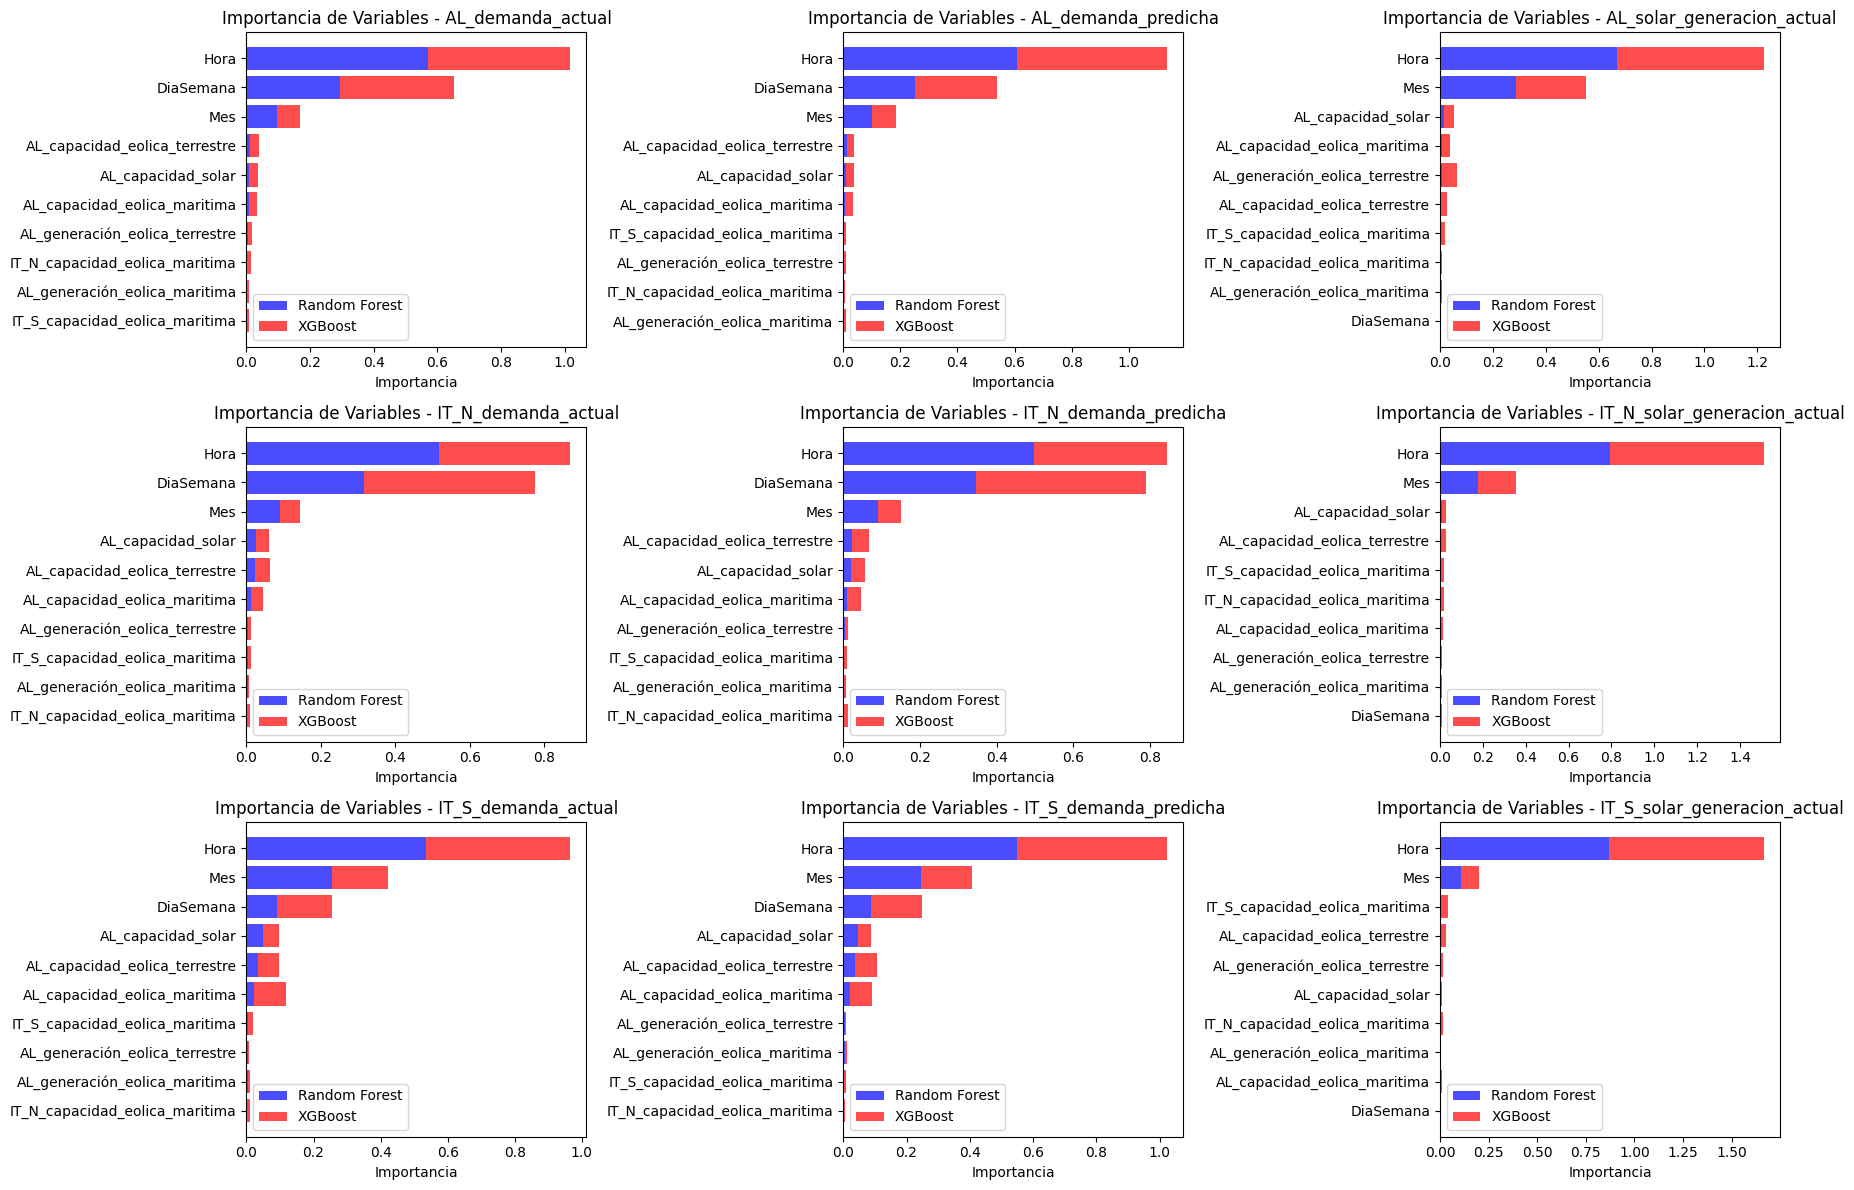

In [ ]:
#Importancia de cada variable:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime
df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Generar variables temporales relevantes
df["Mes"] = df["Fecha_hora"].dt.month
df["DiaSemana"] = df["Fecha_hora"].dt.weekday
df["Hora"] = df["Fecha_hora"].dt.hour

# 6. Definir variables independientes y dependientes
variables_independientes = [
    "AL_capacidad_solar", "AL_capacidad_eolica_maritima", "AL_generación_eolica_maritima",
    "AL_capacidad_eolica_terrestre", "AL_generación_eolica_terrestre",
    "IT_N_capacidad_eolica_maritima", "IT_S_capacidad_eolica_maritima",
    "Mes", "DiaSemana", "Hora"
]

objetivos = [
    "AL_demanda_actual", "AL_demanda_predicha", "AL_solar_generacion_actual",
    "IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"
]

# 7. Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_independientes + objetivos] = scaler.fit_transform(df[variables_independientes + objetivos])

# 8. Reducir el tamaño del dataset para pruebas más rápidas
df_scaled = df_scaled.sample(n=min(55000, len(df_scaled)), random_state=42)

# 9. Entrenar modelos y obtener importancia de variables
importancia_rf = {}
importancia_xgb = {}

for objetivo in objetivos:
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(df_scaled[variables_independientes], df_scaled[objetivo], test_size=0.2, random_state=42)

    # Inicializar modelos
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, tree_method="hist", objective="reg:squarederror", random_state=42)

    # Entrenar modelos
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Guardar importancia de variables
    importancia_rf[objetivo] = rf_model.feature_importances_
    importancia_xgb[objetivo] = xgb_model.feature_importances_

# 10. Crear una figura con múltiples subgráficos
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# 11. Graficar la importancia de las variables para cada objetivo
for i, objetivo in enumerate(objetivos):
    importancia_df = pd.DataFrame({
        "Variable": variables_independientes,
        "Random Forest": importancia_rf[objetivo],
        "XGBoost": importancia_xgb[objetivo]
    }).sort_values(by="Random Forest", ascending=False)

    # Crear el gráfico de barras apiladas en el subplot correspondiente
    axes[i].barh(importancia_df["Variable"], importancia_df["Random Forest"], color="blue", alpha=0.7, label="Random Forest")
    axes[i].barh(importancia_df["Variable"], importancia_df["XGBoost"], color="red", alpha=0.7, left=importancia_df["Random Forest"], label="XGBoost")

    axes[i].set_title(f"Importancia de Variables - {objetivo}")
    axes[i].set_xlabel("Importancia")
    axes[i].invert_yaxis()
    axes[i].legend()

# Ajustar el layout para mejor visualización
plt.tight_layout()
plt.show()




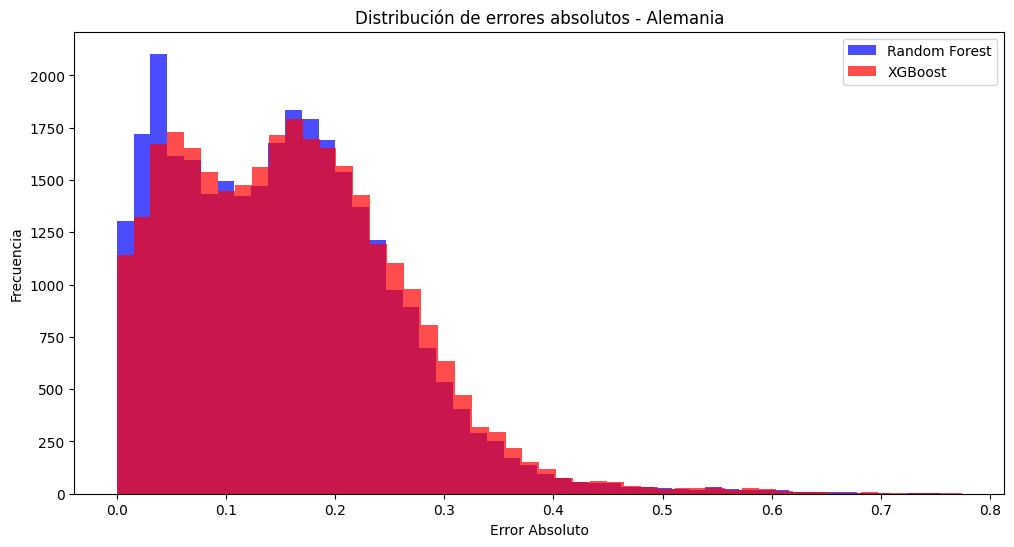

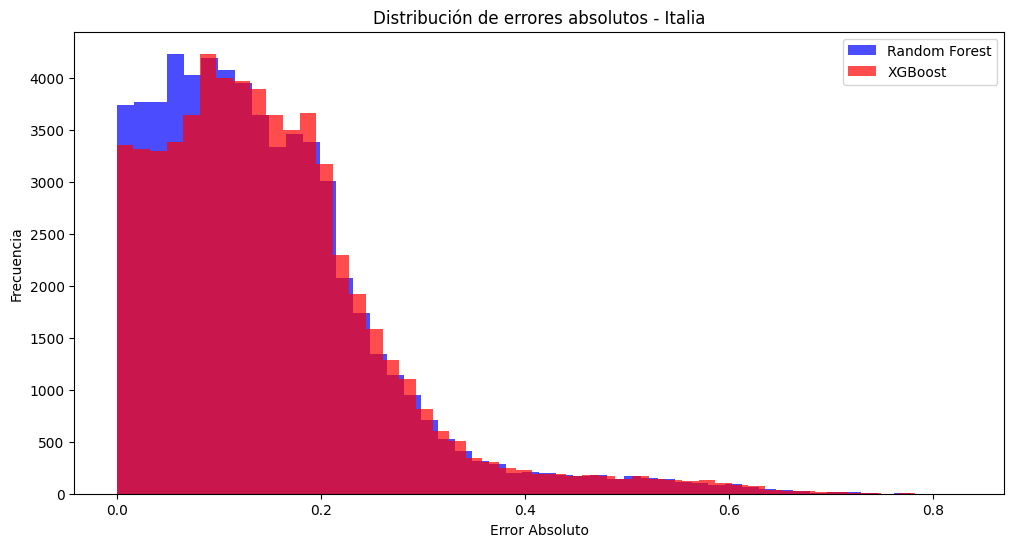

In [ ]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Definir la ruta del archivo
file_path = "/content/BBDD_final_limpio.xlsx"

# 3. Leer el archivo Excel
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 4. Convertir la columna de fecha a datetime si existe
if "Fecha_hora" in df.columns:
    df["Fecha_hora"] = pd.to_datetime(df["Fecha_hora"])

# 5. Definir variables independientes y dependientes por país
variables_alemania = ["AL_demanda_actual", "AL_demanda_predicha", "AL_solar_generacion_actual"]
variables_italia = ["IT_N_demanda_actual", "IT_N_demanda_predicha", "IT_N_solar_generacion_actual",
                    "IT_S_demanda_actual", "IT_S_demanda_predicha", "IT_S_solar_generacion_actual"]

variables_independientes = [col for col in df.columns if col not in variables_alemania + variables_italia + ["Fecha_hora"]]

# 6. Normalizar los datos
scaler = MinMaxScaler()
df[variables_independientes + variables_alemania + variables_italia] = scaler.fit_transform(df[variables_independientes + variables_alemania + variables_italia])

# 7. División en Train y Test (80%-20%) para cada país
X = df[variables_independientes]
train_test_splits_alemania = {
    objetivo: train_test_split(X, df[objetivo], test_size=0.2, random_state=42)
    for objetivo in variables_alemania
}

train_test_splits_italia = {
    objetivo: train_test_split(X, df[objetivo], test_size=0.2, random_state=42)
    for objetivo in variables_italia
}

# 8. Función para calcular errores absolutos y visualización
def calcular_errores_y_graficar(train_test_splits, pais):
    errores_rf = []
    errores_xgb = []

    plt.figure(figsize=(12, 6))

    for i, objetivo in enumerate(train_test_splits):
        X_train, X_test, y_train, y_test = train_test_splits[objetivo]

        # Inicializar modelos
        rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, tree_method="hist", objective="reg:squarederror", random_state=42)

        # Entrenar modelos
        rf_model.fit(X_train, y_train)
        xgb_model.fit(X_train, y_train)

        # Predicciones
        y_pred_rf = rf_model.predict(X_test)
        y_pred_xgb = xgb_model.predict(X_test)

        # Cálculo de errores absolutos
        errores_rf.extend(abs(y_test.values - y_pred_rf))
        errores_xgb.extend(abs(y_test.values - y_pred_xgb))

    # Graficar distribución de errores absolutos
    plt.hist(errores_rf, bins=50, alpha=0.7, color="blue", label="Random Forest")
    plt.hist(errores_xgb, bins=50, alpha=0.7, color="red", label="XGBoost")
    plt.title(f"Distribución de errores absolutos - {pais}")
    plt.xlabel("Error Absoluto")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

# 9. Generar gráficos de errores para Alemania e Italia
calcular_errores_y_graficar(train_test_splits_alemania, "Alemania")
calcular_errores_y_graficar(train_test_splits_italia, "Italia")


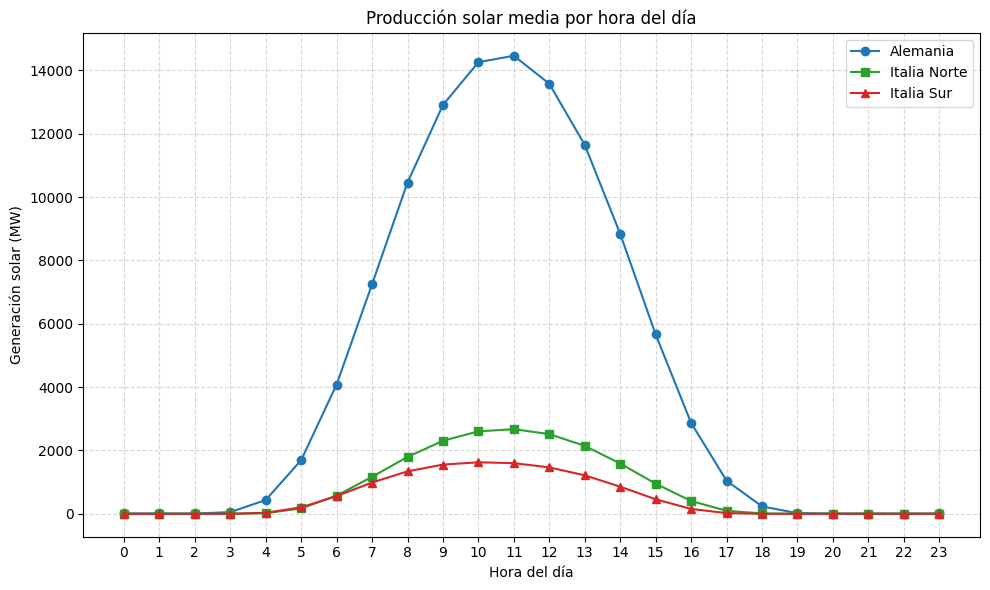

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paso 1: Cargar el archivo
df = pd.read_excel("/content/BBDD_final_limpio.xlsx")

# Paso 2: Convertir fechas y extraer la hora
df['Fecha_hora'] = pd.to_datetime(df['Fecha_hora'])
df['Hora'] = df['Fecha_hora'].dt.hour

# Paso 3: Calcular medias por hora para cada país/región
media_al = df.groupby('Hora')['AL_solar_generacion_actual'].mean()
media_it_n = df.groupby('Hora')['IT_N_solar_generacion_actual'].mean()
media_it_s = df.groupby('Hora')['IT_S_solar_generacion_actual'].mean()

# Paso 4: Graficar comparativa
plt.figure(figsize=(10, 6))
plt.plot(media_al.index, media_al.values, label='Alemania', color='#1f77b4', marker='o')
plt.plot(media_it_n.index, media_it_n.values, label='Italia Norte', color='#2ca02c', marker='s')
plt.plot(media_it_s.index, media_it_s.values, label='Italia Sur', color='#d62728', marker='^')

plt.title("Producción solar media por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Generación solar (MW)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


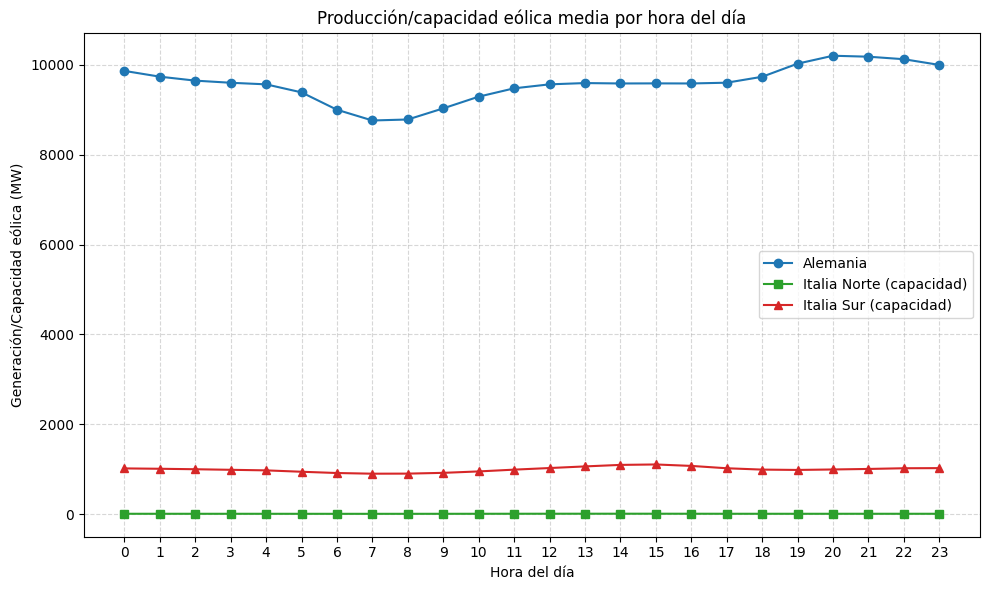

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_excel("/content/BBDD_final_limpio.xlsx")
df['Fecha_hora'] = pd.to_datetime(df['Fecha_hora'])
df['Hora'] = df['Fecha_hora'].dt.hour

# Variables: generación eólica Alemania (directa) + capacidad eólica Italia (como estimación)
media_al = df.groupby('Hora')['AL_generación_eolica_terrestre'].mean()
media_it_n = df.groupby('Hora')['IT_N_capacidad_eolica_maritima'].mean()
media_it_s = df.groupby('Hora')['IT_S_capacidad_eolica_maritima'].mean()

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(media_al.index, media_al.values, label='Alemania', color='#1f77b4', marker='o')
plt.plot(media_it_n.index, media_it_n.values, label='Italia Norte (capacidad)', color='#2ca02c', marker='s')
plt.plot(media_it_s.index, media_it_s.values, label='Italia Sur (capacidad)', color='#d62728', marker='^')

plt.title("Producción/capacidad eólica media por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Generación/Capacidad eólica (MW)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


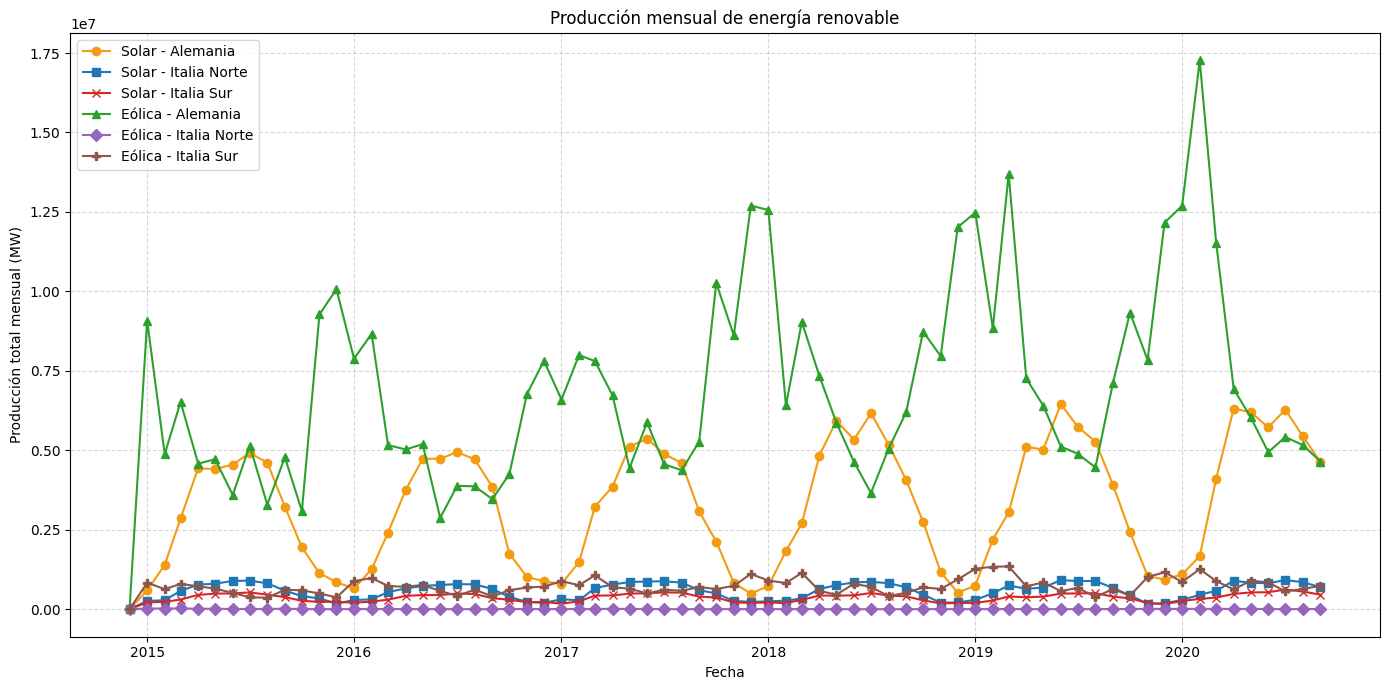

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo
df = pd.read_excel("/content/BBDD_final_limpio.xlsx")
df['Fecha_hora'] = pd.to_datetime(df['Fecha_hora'])
df['Año'] = df['Fecha_hora'].dt.year
df['Mes'] = df['Fecha_hora'].dt.month

# Agrupar por mes y año
df_mes = df.groupby(['Año', 'Mes'])[
    [
        'AL_solar_generacion_actual',
        'IT_N_solar_generacion_actual',
        'IT_S_solar_generacion_actual',
        'AL_generación_eolica_terrestre',
        'IT_N_capacidad_eolica_maritima',
        'IT_S_capacidad_eolica_maritima'
    ]
].sum().reset_index()

# Crear columna para eje X
df_mes['Fecha'] = pd.to_datetime(df_mes['Año'].astype(str) + '-' + df_mes['Mes'].astype(str))

# Graficar
plt.figure(figsize=(14, 7))

plt.plot(df_mes['Fecha'], df_mes['AL_solar_generacion_actual'], label='Solar - Alemania', color='#f39c12', marker='o')
plt.plot(df_mes['Fecha'], df_mes['IT_N_solar_generacion_actual'], label='Solar - Italia Norte', color='#1f77b4', marker='s')
plt.plot(df_mes['Fecha'], df_mes['IT_S_solar_generacion_actual'], label='Solar - Italia Sur', color='#d62728', marker='x')
plt.plot(df_mes['Fecha'], df_mes['AL_generación_eolica_terrestre'], label='Eólica - Alemania', color='#2ca02c', marker='^')
plt.plot(df_mes['Fecha'], df_mes['IT_N_capacidad_eolica_maritima'], label='Eólica - Italia Norte', color='#9467bd', marker='D')
plt.plot(df_mes['Fecha'], df_mes['IT_S_capacidad_eolica_maritima'], label='Eólica - Italia Sur', color='#8c564b', marker='P')

plt.title("Producción mensual de energía renovable")
plt.xlabel("Fecha")
plt.ylabel("Producción total mensual (MW)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
